# Youtube Comments Analysis

## Imports

In [1]:
import os
import random
from collections import namedtuple, defaultdict
from datetime import datetime
import re
from tqdm import tqdm

from typing import List
import numpy as np
import pandas as pd
from glob import glob
import json
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, HDBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples
import umap.umap_ as umap
from sklearn.manifold import TSNE
from scipy.spatial import distance
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import wordcloud

/home/kilian/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# My own modules
from util.string_utils import split_text_if_long
from models.text_models import TextModelManager
from models.computations import ClassificationType
from models.math_funcs import cos_sim
from models.llm_api import LLM
from api.youtube_api import YoutubeAPI
from analysis.classification_analysis import ClassificationAnalyzer

/home/kilian/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Logging
import logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level
    format='%(asctime)s.%(msecs)03d - %(name)s - %(levelname)s - %(message)s',  # Define the log format with milliseconds
    datefmt='%Y-%m-%d %H:%M:%S'  # Define the date and time format without milliseconds
)

## Load Models

In [4]:
# Initialize classification models
text_model_manager = TextModelManager()

2024-07-15 09:43:48.779 - models.text_models - INFO - Instantiating TextModelManager.


## Set up LLM

In [5]:
llm = LLM()

## Youtube API

In [6]:
youtube = YoutubeAPI()

2024-07-15 09:43:48.825 - googleapiclient.discovery_cache - INFO - file_cache is only supported with oauth2client<4.0.0


In [7]:
yt_video_test_id_tomato = "9WQnap-UAiQ"
yt_video_test_id_10k_comments = "2-XxbdR3Nik"
yt_video_test_id_4500_comments = "-ih0B9yn32Q"
yt_video_test_id_4k_comments_beard_meets_schnitzel = "qPd9qPUR2_U"
yt_video_test_id_2000_comments = "rX2tK-qSVpk"
yt_video_test_id_700_comments = "VCXqELB3UPg"
yt_video_test_id_300_comments = "yQqJafC7xv0"
yt_video_test_id_25_comments = "kiF0wgM8zGc"
yt_video_test_id_50_comments = "LHQMIuzjl48"

yt_video_id = yt_video_test_id_50_comments
youtube.set_current_video(yt_video_id)

In [8]:
youtube.get_title()

'Perfect OFFICE Custom Keyboard!'

In [9]:
youtube.get_creator_name()

'Lewis Toh'

## Classification Analysis

In [10]:
# Get comments (for testing)
comments = youtube.get_comments(yt_video_id)

2024-07-15 09:43:49.029 - api.youtube_api - INFO - Starting raw comment retrieval.
2024-07-15 09:43:49.164 - api.youtube_api - INFO - Received 31 top-level comments.
2024-07-15 09:43:49.165 - api.youtube_api - INFO - Finished raw comment retrieval of 31 top-level comments.


Starting comments retrieval for video ID LHQMIuzjl48 ('Perfect OFFICE Custom Keyboard!')


Getting replies for comments with missing replies ...: 100%|██████████| 31/31 [00:00<00:00, 56117.14it/s]
Deduplicating comments ...: 100%|██████████| 31/31 [00:00<00:00, 13132.35it/s]


In [11]:
classification_analyzer = ClassificationAnalyzer(comments)
print(classification_analyzer.run_all_analyses())

Determining computated facts (Sentiment; argmax=False) ...: 100%|██████████| 31/31 [00:01<00:00, 19.32it/s]
Determining computated facts (Sentiment; argmax=True) ...: 100%|██████████| 31/31 [00:00<00:00, 83082.06it/s]
Determining computated facts (Sentiment; argmax=False) ...: 100%|██████████| 51/51 [00:00<00:00, 97.00it/s] 
Determining computated facts (Sentiment; argmax=True) ...: 100%|██████████| 51/51 [00:00<00:00, 136770.78it/s]
Determining computated facts (Toxicity; argmax=False) ...: 100%|██████████| 31/31 [00:03<00:00,  9.85it/s]
Determining computated facts (Toxicity; argmax=True) ...: 100%|██████████| 31/31 [00:00<00:00, 56189.90it/s]
Determining computated facts (Toxicity; argmax=False) ...: 100%|██████████| 51/51 [00:01<00:00, 39.51it/s]
Determining computated facts (Toxicity; argmax=True) ...: 100%|██████████| 51/51 [00:00<00:00, 75639.85it/s]
Determining computated facts (Emotion; argmax=False) ...: 100%|██████████| 31/31 [00:02<00:00, 10.65it/s]
Determining computated f

All results are weighted by comment likes.
Classification (Sentiment) analysis for top-level comments:
(Soft) Mean Sentiment for 31 comments:
positive:           42.06%
negative:           36.20%
neutral:            21.74%
(Hard) Mean Sentiment for 31 comments:
positive:           60.29%
negative:           26.47%
neutral:            13.24%

Classification (Sentiment) analysis for all comments:
(Soft) Mean Sentiment for 51 comments:
positive:           45.57%
negative:           33.51%
neutral:            20.92%
(Hard) Mean Sentiment for 51 comments:
positive:           64.44%
negative:           25.56%
neutral:            10.00%

10 most positive comments: 
Comment(@LewisToh @ 2024-02-02T16:31:16+00:00: 'nice!') (0 likes; 0 replies)
Comment(@ItsNoah_ @ 2024-02-02T14:08:46+00:00: 'I love that you always notify people for the best keyboards in the market') (6 likes; 1 replies)
Comment(@johntee2012 @ 2024-02-02T17:15:36+00:00: 'I like it, looks super clean. Good video <3') (1 likes; 0 re

### Sentiment + Meaning
What are positive comments saying vs. what are negative comments saying?

In [12]:
def get_max_class(computation_result):
    max_idx = np.argmax(computation_result.values())
    return list(computation_result.keys())[max_idx]

In [13]:
# Group comments by sentiment
sentiment_groups = defaultdict(list)

for comm in tqdm(comments, "Grouping by sentiment ..."):
    comp = comm.get_classification(ClassificationType.Sentiment)
    sen = get_max_class(comp)
    magnitude = comp[sen]
    if magnitude > 0.75:
        sentiment_groups[sen].append(comm)

Grouping by sentiment ...: 100%|██████████| 31/31 [00:00<00:00, 60476.01it/s]


In [14]:
for sen, sen_comments in sentiment_groups.items():
    print(f"- {len(sen_comments)} {sen} comments.")

- 6 positive comments.


positive


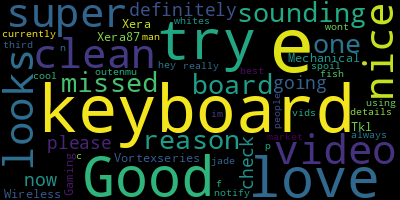

In [15]:
# Show word clouds
for sen, sen_comments in sentiment_groups.items():
    print(sen)
    wc = wordcloud.WordCloud()
    wc.generate(" ".join([comm.text for comm in sen_comments]))
    display(wc.to_image())
    print()

In [16]:
assert False

AssertionError: 

### LLM Statement Extraction

In [ ]:
double_newline = "\n\n"

In [ ]:
def truncate_line(text, max_length):
    if len(text) > max_length:
        text = text[:max_length]
        text = " ".join(text.split()[:-1])
        text += "..."
    return text

In [ ]:
def sample_from_comments(comments, max_chars_per_comment=200, max_comment_chars_shown=2500):
    comments = list(comments)
    comm_lines = []
    random.shuffle(comments)
    idx = 0
    while (sum(len(l) for l in comm_lines) < max_comment_chars_shown) and (idx < len(comments)):
        comm = comments[idx]
        text = comm.text
        while double_newline in text:
            text = text.replace(double_newline, "\n")
        if len(text) > max_chars_per_comment:
            text = truncate_line(text, max_chars_per_comment)
        comm_lines.append(f"- \"{text}\"")
        idx += 1
    return comm_lines

In [ ]:
def build_prompt_extract_statements(video_info, comments: List[Comment]):
    title = get_title(video_info)
    lines = [f"You are a professional YouTube comment analyst. Given a video title and some comments, extract statements from the comments."]
    lines.append(f"Video title: {title}")
    
    lines.append("\nSample from the comments:")
    comm_lines = sample_from_comments(comments)
    lines += comm_lines

    lines.append("\nExtract 5 statements voiced in the comments. A statement should be a simple thought expressed by many comments, e.g., \"The video was well-edited.\" or \"I disagree with the premise of the video.\". Phrase each statement in a way it could be uttered by a viewer of the video. " \
                 "Do not explain any of the statements you extract. " \
                 "There is no need to repeat the video title in your assessment.")

    prompt = "\n".join(lines)
    return prompt

In [ ]:
def post_process_extract_statements(raw):
    lines = raw.split("\n")
    lines = [l for l in lines if len(l) > 0]  # remove blank lines

    # Look for enumeration at the start of the line (keep lines such as those starting with "4. ", "15.", "- ", or "• ")
    matched = [(l, re.search("^(\d+\.|-|•|\*)", l)) for l in lines]
    matched = [(l, m) for (l, m) in matched if m is not None]

    # Remove enumeration at the start of the line
    lines = [l[m.span()[-1]:] for (l, m) in matched]

    # Strip lined
    lines = [l.strip() for l in lines]
    
    return lines

In [ ]:
# Extract statements from positive and negative comments
comment_statements = {}
msg_str = ""
for sen, sen_comments in sentiment_groups.items():
    msg_str += f" {sen.capitalize()} Sentiment Comments ".center(50, "-")
    msg_str += "\n"

    # Construct the LLM prompt and summarize the comments
    prompt = build_prompt_extract_statements(info, sen_comments)
    res_raw = llm.chat(prompt)
    res_lines = post_process_extract_statements(res_raw)
    comment_statements[sen] = res_lines
    msg_str += "\n".join([f"- {l}" for l in res_lines]) + "\n\n"

In [ ]:
print(msg_str)

In [ ]:
comment_statements

In [ ]:
# For testing, reduce the number of statements
comment_statements = {kind: [statements[idx] for idx in np.random.choice(np.arange(len(statements)), size=min(len(statements), 2), replace=False)] for (kind, statements) in comment_statements.items()}
comment_statements

In [ ]:
agreement_prompt_settings = {
    "min": -5,
    "neut": 0,
    "max": 5
}

In [ ]:
# Generate opposite statements
def build_prompt_do_statements_agree(video_info, statement_1, statement_2):
    title = get_title(video_info)
    lines = ["You are a professional YouTube video comment analyst. Given a video title and a statement (or a comment) about the video, decide if the statements two agree. Note that it may be possible for a statement or a comment to express the desire for change or to voice disagreement."]
    lines.append(f"Video title: {title}")
    lines.append(f"Statement 1: {statement_1}")
    lines.append(f"Statement 2: {statement_2}")

    lines.append("\nA statement is a simple thought expressed by many comments, e.g., \"The video was well-edited.\" or \"I disagree with the premise of the video.\".")
    lines.append(f"First, think step by step about the two statements to determine if they agree. Finally, give your assessment of the agreement on a scale of {agreement_prompt_settings['min']} for total disagreement to {agreement_prompt_settings['max']} for total agreement. " \
                f"The number {agreement_prompt_settings['neut']} is for unrelated statements (those which discuss different matters). Even if the sentiments of the statements are opposite: If they discuss different matters, the assessment should be {agreement_prompt_settings['neut']}. " \
                 "Provide your assessment in the form of JSON such as {\"agreement\": your_number_goes_here}.")

    prompt = "\n".join(lines)
    return prompt

In [ ]:
def post_process_single_entry_json(raw):
    # Split into lines
    lines = raw.split("\n")

    # Beginning from the bottom, try to read JSON using a regex
    pattern = r'\{.*?\}'
    jso = None
    for line in reversed(lines):
        # Match regex
        matches = re.findall(pattern, line)
        
        if len(matches) == 0:
            continue

        # Parse json
        for m in reversed(matches):
            try:
                jso = json.loads(m)
                break
            except:
                pass

        if jso is not None:
            break

    # Abort if we did not find JSON
    if jso is None:
        return None

    # Extract only key in json
    if len(jso) > 1:
        return None  # invalid json
    val = list(jso.values())[0]
    
    return val

In [ ]:
# Create directory for saving agreements to disk
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

In [ ]:
# Utility function for line count
def get_line_count(path):
    with open(path, "rb") as f:
        num_lines = sum(1 for _ in f)
    return num_lines

In [ ]:
# Snippet saving function - will automatically chunk saved information into files
def save_snippet(sni, name, max_entries_per_file=1000):
    # Make a DataFrame with the new piece of information
    df = pd.DataFrame([sni])

    # Make destination directory
    directory = os.path.join(data_dir, name)
    os.makedirs(directory, exist_ok=True)

    # Inspect already present files
    found_files = sorted(glob(os.path.join(directory, "*.csv")))
    if len(found_files) > 0:
        # Find out ID of last file
        last_path = found_files[-1]
        last_filename = os.path.split(last_path)[-1]
        last_filename = os.path.splitext(last_filename)[0]
        file_id = int(last_filename.split("_")[-1])

        # Find out its number of entries
        num_entries = get_line_count(last_path) - 1
        if num_entries >= max_entries_per_file:
            # Create a new file
            file_id += 1
        else:
            # Load the file and append to it
            df_old = pd.read_csv(last_path)
            df = pd.concat([df_old, df])
    else:
        file_id = 0

    # Save file
    filename = f"{name}_{file_id:06d}.csv"
    df.to_csv(os.path.join(directory, filename), index=False)

In [ ]:
# Full process of agreement check
def do_statements_agree(video_info, statement_1, statement_2, verbose=False):
    # Make prompt
    prompt = build_prompt_do_statements_agree(video_info, statement_1, statement_2)

    # Send prompt to LLM
    res_raw = llm.chat(prompt)
    if verbose:
        print(f"Raw LLM response: {res_raw}")
    rating = post_process_single_entry_json(res_raw)

    # Save this snippet of information to a file
    save_snippet(
        {
            "statement_1": statement_1,
            "statement_2": statement_2,
            "video_title": get_title(video_info),
            "agreement_rating": rating
        },
        "agreements"
    )

    return rating

In [ ]:
# Get the top k comments, according to likes
k = 2
comments_topk = sorted(comments, key=lambda comm: comm.likes, reverse=True)[:k]
comments_topk[:5]

In [ ]:
agreement_positive = "agree"
agreement_neutral = "neutral"
agreement_negative = "disagree"
agreements_nonneutral = [agreement_positive, agreement_negative]

In [ ]:
statement_scores_raw = defaultdict(list)
statement_agreements_raw = defaultdict(dict)

statements = sum(comment_statements.values(), [])  # get all statements, regardless of kind
comparisons_all = list(itertools.product(statements, comments_topk))
for statement, comment in tqdm(comparisons_all, desc="Measuring statement agreement with comments ..."):
    # Find out agreement between statement and comment
    agreement = do_statements_agree(
        video_info=info,
        statement_1=statement,
        statement_2=comment.text
    )

    # Calculate agreement score
    likes = comment.likes
    score = agreement * likes

    # Add measured score to the statement's score
    statement_scores_raw[statement].append(score)

    # Add likes to agreement class
    agreement_class = agreement_positive if agreement > 0 else (agreement_negative if agreement < 0 else agreement_neutral)
    tally = statement_agreements_raw[statement]
    if agreement_class not in tally:
        tally[agreement_class] = []
    tally[agreement_class].append(likes)

In [ ]:
# Get total like count to "normalize" scores
total_likes = np.sum([comm.likes for comm in comments_topk])

In [ ]:
# Normalize scores by using total like count
statement_scores_norm = {statement: [s / total_likes for s in scores] for (statement, scores) in statement_scores_raw.items()}

In [ ]:
# Sum agreements to get scores
statement_scores_total = {statement: np.sum(scores) for (statement, scores) in statement_scores_norm.items()}

In [ ]:
for statement, score in statement_scores_total.items():
    print(f"Statement '{statement}'".ljust(15 + max(len(s) for s in statements)) + f"->" + f"{score:0.2f}".rjust(9))

In [ ]:
# Consider the fraction of comments (weighted by likes) that agree, are neutral, or disagree
statement_agreements_norm = {statement: {opinion: sum(likes) / total_likes for (opinion, likes) in agree_info.items()} for (statement, agree_info) in statement_agreements_raw.items()}

In [ ]:
for statement, agree_info in statement_agreements_norm.items():
    # Remove neutral votes (but remember them)
    frac_neutral = agree_info.get(agreement_neutral, 0)
    frac_engaged = 1 - frac_neutral

    # Re-normalize other votes
    if frac_neutral > 0:
        prob_mass = sum(agree_info.get(opinion, 0) for opinion in agreements_nonneutral)
        agree_info = {opinion: frac / prob_mass for (opinion, frac) in agree_info.items()}

    # Sort opinions alphabetically and keep only non-neutral opinions
    agree_info = sorted(agree_info.items(), key=lambda t: t[0])
    agree_info = [(opinion, fraction) for (opinion, fraction) in agree_info if opinion in agreements_nonneutral]

    # Format everything
    statement_str = f"Statement '{statement}'".ljust(15 + max(len(s) for s in statements))
    if frac_engaged > 0:
        engagement_str = f"{100 * frac_engaged:0.2f}% are discussing this, out of those "
        opinion_str = ", ".join(f"{100 * fraction:0.0f}% {opinion}" for (opinion, fraction) in agree_info).center(24)
        discussion_str = engagement_str + opinion_str
    else:
        discussion_str = "No comments (of those checked) are discussing this."
    
    print(statement_str + f"->  " + discussion_str)

## Embedding and Clustering

Here, our goal is to find out trends or common themes in the comments.

In [ ]:
comments_for_clustering = flatten_comments(comments)

In [ ]:
emb_vecs = []
for comm in tqdm(comments_for_clustering, desc="Calculating embeddings ..."):
    emb_vecs.append(comm.get_embedding())

In [ ]:
emb_matrix = np.stack(emb_vecs)
emb_matrix.shape

Let's cluster.

In [ ]:
def cluster_kmeans(matrix, n=5):
    clustering_method = KMeans(n_clusters=n)
    clustering_method.fit(matrix)
    return clustering_method.labels_

In [ ]:
def cluster_spectral_clustering(matrix, n=5):
    clustering_method = SpectralClustering(n_clusters=n)
    clustering_method.fit(matrix)
    return clustering_method.labels_

In [ ]:
def cluster_dbscan(matrix, n=5):
    # argument `n` is ignored
    clustering_method = DBSCAN()
    clustering_method.fit(matrix)
    return clustering_method.labels_

In [ ]:
def cluster_optics(matrix, n=5):
    # argument `n` is ignored
    clustering_method = OPTICS()
    clustering_method.fit(matrix)
    return clustering_method.labels_

In [ ]:
def cluster_hdbscan(matrix, n=5):
    # argument `n` is ignored
    clustering_method = HDBSCAN()
    clustering_method.fit(matrix)
    return clustering_method.labels_

In [ ]:
def cluster_gmm(matrix, n=5):
    clustering_method = GaussianMixture(n_components=n)
    clustering_method.fit(matrix)
    labels = clustering_method.predict(matrix)
    return labels

In [ ]:
def eval_clustering(matrix, labels):
    labs_unique = list(np.unique(labels))
    
    # Silhouette score for each sample (i.e., comment)
    try:
        sil_all = silhouette_samples(matrix, labels)
    except ValueError:
        # this may happen if there is only one label
        sil_all = np.copy(labels)
        sil_all.fill(-1)  # worst possible value
    
    # Silhouette score, aggregated by cluster
    sil_for_labels = [np.mean(sil_all[np.where(labels == lab)[0]]) for lab in labs_unique]
    
    return labs_unique, sil_for_labels

In [ ]:
clusterings = []
n_range = [2, 3, 4, 5, 6, 7, 8, 16, 32, 64]
clus_funs = [cluster_kmeans, cluster_gmm, cluster_spectral_clustering, cluster_hdbscan]

In [ ]:
for n, clus_fun in tqdm(list(itertools.product(n_range, clus_funs)), desc="Clustering ..."):
    # Cluster
    labels = clus_fun(emb_matrix, n=n)

    # Evaluate
    labs_unique, sil_for_labels = eval_clustering(emb_matrix, labels)
    
    clusterings.append((labels, labs_unique, sil_for_labels, n, clus_fun))

In [ ]:
# Remove clustering if it is degenerate (i.e., the majority of points are in a single cluster)
cluster_sizes = [[len(np.where(labels == lab)[0]) / len(labels) for lab in labs_unique] for (labels, labs_unique, _, _, _) in clusterings]
cluster_sizes = [(idx, si, min(2 / len(si), 0.8)) for (idx, si) in enumerate(cluster_sizes)]
legal_indices = [idx for (idx, si, limit) in cluster_sizes if (max(si) <= limit)]
clusterings = [clusterings[idx] for idx in legal_indices]

In [ ]:
print(f"After filtering out degenerate clusterings, proceeding with {len(clusterings)} clusterings.")

In [ ]:
# Sort by mean of Silhouette coefficient: largest first
clusterings.sort(key=lambda t: np.mean(t[2]), reverse=True)

In [ ]:
# Find the best clustering
labels, labs_unique, sil_for_labels, n, clus_fun = clusterings[0]
print(f"Best clustering out of {len(clusterings)} is with n = {n}, with a mean Silhouette coefficient of {np.mean(sil_for_labels):0.8f} (function was {clus_fun}).")

In [ ]:
# Prepare colormap for plotting
cm_steps = len(labs_unique)

In [ ]:
hsv = mpl.colormaps.get_cmap('hsv')
cmap = mpl.colors.ListedColormap(hsv(np.linspace(0,1,cm_steps + 1)[:-1]))
cmap

In [ ]:
def color_for_idx(idx, colormap):
    return colormap.colors[idx]

In [ ]:
def color_for_label(label, labels_unique, colormap):
    idx = labels_unique.index(label)
    return color_for_idx(idx, colormap)

In [ ]:
def plot(matrix, labels_unique, labels, use_umap=True):
    if use_umap:
        # Use UMAP
        reducer = umap.UMAP()
    else:
        # Use t-SNE
        reducer = TSNE(
            n_components=2,
            learning_rate='auto',
            init='random',
            perplexity=3
        )

    # Fit
    matrix_2d = reducer.fit_transform(matrix)

    # Plot
    plt.scatter(x=matrix_2d[:, 0], y=matrix_2d[:, 1], c=[color_for_label(lab, labels_unique, cmap) for lab in labels])

In [ ]:
plot(emb_matrix, labs_unique, labels)

In [ ]:
def build_prompt_find_topic(video_info, comments: List[Comment]):
    title = get_title(video_info)
    lines = [f"You are a professional YouTube comment analyst. Given a video title and some comments, find the topic of the comments."]
    lines.append(f"Video title: {title}")
    
    lines.append("\nSample from the comments:")
    comm_lines = sample_from_comments(comments)
    lines += comm_lines

    lines.append("\nExtract a single, coherent topic that these comments are discussing. The topic you find can also be about the style or mood of the comments. " \
                 "A topic should be a simple notion, e.g., \"Jokes\" or \"Choosing a keyboard\"." \
                 "There is no need to repeat the video title in your assessment. The topic should also describe what the comments are saying, so it shouldn't be, e.g., \"Reactions to Video\" or anything generic of that sort. Provide your assessment in the form of JSON such as {\"topic\": your_topic_goes_here}.")

    prompt = "\n".join(lines)
    return prompt

In [ ]:
divider_width = 100
divider_str = "-"
show_random_comments = False
cluster_topics = {}

In [ ]:
def describe_clusters():
    for lab in labs_unique:
        print(f"Cluster Description (Label {lab})".center(divider_width, divider_str))
    
        # Size
        cluster_size = sum(labels == lab)
        print(f"- Cluster size: {cluster_size} ({100 * cluster_size / len(labels):0.2f}%)")
    
        # Get indices
        clus_indices = np.where(labels == lab)[0]
        
        # Find mean embedding of cluster
        clus_mean_emb = np.mean(np.stack([emb_matrix[idx] for idx in clus_indices]), axis=0)
        
        # Sort comments by distance to mean embedding
        clus_comments = [comments_for_clustering[idx] for idx in clus_indices]
        clus_comments.sort(key=lambda comment: np.sum(np.abs(comment.get_embedding()) - clus_mean_emb))
    
        # Find out central topic of cluster
        if lab not in cluster_topics:
            clus_comments_central = clus_comments[:1000]
            prompt = build_prompt_find_topic(info, clus_comments_central)
            res_raw = llm.chat(prompt)
            topic = post_process_single_entry_json(res_raw)
            cluster_topics[lab] = topic
        print(f"- Central topic (LLM): {cluster_topics[lab]}")
    
        # Show comment closest to the mean
        print("- Comment closest to mean embedding:")
        print(clus_comments[0])
    
        # Show random comments
        if show_random_comments:
            rnd_indices = np.random.choice(clus_indices, size=min(5, cluster_size), replace=False)
            print()
            print(f"- {len(rnd_indices)} random comments from this cluster: ")
            for idx in rnd_indices:
                print(f"- {comments_for_clustering[idx]}")
    
        print("".center(divider_width, divider_str))
        
        print()

In [ ]:
describe_clusters()

### Fuse clusters based on topic

In [ ]:
cluster_groups = [[]]

In [ ]:
for lab, topic in cluster_topics.items():
    # Store this cluster label and topic as a tuple
    tup = (lab, topic)
    
    # Try to find a spot for this topic in one of the groups
    found_group = False
    for group in cluster_groups:

        # If the group is empty, add the cluster (this only happens at the beginning)
        if len(group) == 0:
            group.append(tup)
            found_group = True
            break

        # Compare this cluster's embedding with the group
        mean_sim = np.mean([cos_sim(text_model_manager.embed(top), text_model_manager.embed(topic)) for (l, top) in group])
        if mean_sim > 0.55:
            group.append(tup)
            found_group = True
            break

    # If we already found a group, go on to the next cluster's topic
    if found_group:
        continue

    # Start a new group
    cluster_groups.append([tup])

In [ ]:
def build_prompt_fuse_topics(video_info, topics: List[str]):
    title = get_title(video_info)
    lines = [f"You are a professional YouTube comment analyst. Given a video title and some comment topics, find a new description of the topic that reflects the core concept of the listed topics."]
    lines.append(f"Video title: {title}")
    
    lines.append("\nComment topics:")
    lines += [f"- {t}" for t in topics]

    lines.append("\nExtract a single, coherent topic that describes all these topics. The topic you find can also be about the style or mood of the comments. " \
                 "A topic should be a simple notion, e.g., \"Jokes\" or \"Choosing a keyboard\"." \
                 "There is no need to repeat the video title in your assessment. The topic shouldn't be, e.g., \"Reactions to Video\" or anything generic of that sort. Provide your assessment in the form of JSON such as {\"topic\": your_topic_goes_here}.")

    prompt = "\n".join(lines)
    return prompt

In [ ]:
# Fuse groups we found by finding a new topic
fused_groups = []
for group in tqdm(cluster_groups, desc="Fusing groups ..."):
    labs, topics = zip(*group)

    if len(topics) > 1:
        prompt = build_prompt_fuse_topics(info, topics)
        res_raw = llm.chat(prompt)
        topic = post_process_single_entry_json(res_raw)
    else:
        topic = topics[0]

    fused_groups.append((labs, topic))

In [ ]:
# Change labeling of clustering to reflect group fusions
for label_group, topic in fused_groups:
    # No need to change any labels if we "group" doesn't have multiple labels
    if len(label_group) <= 1:
        continue

    # Paint all labels in group to match the first label
    label_group = list(label_group)
    lab_first = label_group.pop(0)
    for lab in label_group:
        labels[np.where(labels == lab)] = lab_first

    # Remember topic
    cluster_topics[lab_first] = topic

In [ ]:
labs_unique = list(np.unique(labels))

In [ ]:
plot(emb_matrix, labs_unique, labels)

In [ ]:
describe_clusters()